**Initial step:** Please try to put the extracted heavy_makeup_CelebA folder in 

*   List item
*   List item

your Google Drive!
So now you could mount your data to this ipynb!

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# if you mount Google drive correctly, the following commands should be able to be executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive/Colab Notebooks/HW4_updated1/"
%cd "heavy_makeup_CelebA"

!ls

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

plt.ion()   # interactive mode

In [0]:
## Please try to adjust data augmentation strategy here
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(brightness=0.5, contrast=(0.6, 1.6), saturation=(0.8, 1.5)),
        transforms.RandomRotation((-10, 10)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the directory of your data in Google Drive
data_dir = '/content/drive/My Drive/Colab Notebooks/HW4_updated1/heavy_makeup_CelebA'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [0]:
def reset(seed=998):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

Let's show some training data. Make sure the lables match the images

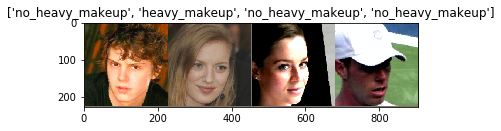

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc = {
        'train': [],
        'val': []
    }
    loss_list = {
        'train': [],
        'val': []
    }


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)                            
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            acc[phase].append(epoch_acc)
            loss_list[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc, loss_list

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def plot_acc_loss(acc, loss, title, acc_color=None, loss_color=None):
  plt.plot(list(range(len(acc['train']))), acc['train'], color=acc_color)
  plt.plot(list(range(len(acc['val']))), acc['val'], color=acc_color)
  plt.xlabel('epoch')
  plt.ylabel('acc')
  plt.legend(['train_acc', 'val_acc'])
  plt.title(title)
  plt.show()
  plt.plot(list(range(len(loss['train']))), loss['train'], color=loss_color)
  plt.plot(list(range(len(loss['val']))), loss['val'], color=loss_color)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train_loss', 'val_loss'])
  plt.title(title)
  plt.show()

**Case 1:**
using ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [0]:
reset()

In [0]:
model_conv = models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier = model_conv.classifier[:-1] # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_conv.classifier.add_module('6', addition_fc)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:01<00:00, 166MB/s]


Let's train the model as a feature extractor

In [0]:
model_conv, model_acc, model_loss = train_model(model_conv, criterion, optimizer_conv,
                                                exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1202 Acc: 0.7210
val Loss: 2.3166 Acc: 0.7675

Epoch 1/24
----------
train Loss: 2.3357 Acc: 0.7580
val Loss: 1.5426 Acc: 0.7725

Epoch 2/24
----------
train Loss: 1.9848 Acc: 0.7725
val Loss: 2.1410 Acc: 0.7800

Epoch 3/24
----------
train Loss: 1.9380 Acc: 0.7665
val Loss: 1.3031 Acc: 0.7550

Epoch 4/24
----------
train Loss: 2.2504 Acc: 0.7535
val Loss: 2.1481 Acc: 0.7975

Epoch 5/24
----------
train Loss: 1.3386 Acc: 0.8120
val Loss: 0.9571 Acc: 0.8025

Epoch 6/24
----------
train Loss: 1.0702 Acc: 0.8165
val Loss: 0.8140 Acc: 0.8000

Epoch 7/24
----------
train Loss: 1.0503 Acc: 0.8055
val Loss: 0.8249 Acc: 0.8075

Epoch 8/24
----------
train Loss: 1.0400 Acc: 0.8035
val Loss: 0.9194 Acc: 0.8125

Epoch 9/24
----------
train Loss: 0.9128 Acc: 0.8225
val Loss: 0.8533 Acc: 0.7975

Epoch 10/24
----------
train Loss: 0.8858 Acc: 0.8160
val Loss: 0.8085 Acc: 0.8000

Epoch 11/24
----------
train Loss: 0.8467 Acc: 0.8110
val Loss: 0.8022 Acc: 0.8000

Ep

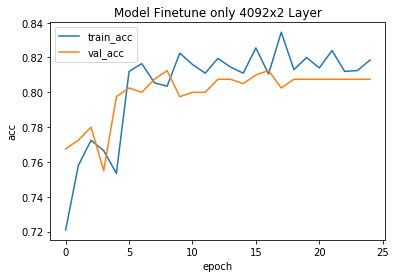

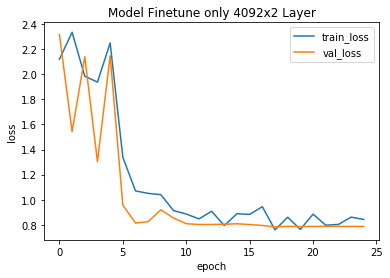

In [0]:
plot_acc_loss(model_acc, model_loss, 'Model Finetune only 4092x2 Layer')

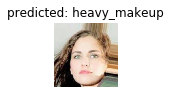

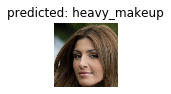

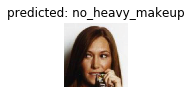

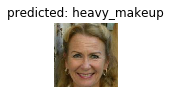

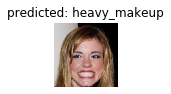

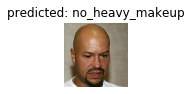

In [0]:
visualize_model(model_conv)

**Case 2**: Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [0]:
reset()

In [0]:
## Alexnet
model_ft = models.alexnet(pretrained=True)
model_ft.classifier = model_ft.classifier[:-1]  # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_ft.classifier.add_module('6', addition_fc)
#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_ft)
##

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than 5 minutes.

In [0]:
model_ft, model_ft_acc, model_ft_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5952 Acc: 0.6955
val Loss: 0.5339 Acc: 0.7850

Epoch 1/24
----------
train Loss: 0.5042 Acc: 0.7690
val Loss: 0.3738 Acc: 0.8175

Epoch 2/24
----------
train Loss: 0.4144 Acc: 0.8180
val Loss: 0.4375 Acc: 0.8100

Epoch 3/24
----------
train Loss: 0.3714 Acc: 0.8390
val Loss: 0.4650 Acc: 0.8450

Epoch 4/24
----------
train Loss: 0.3708 Acc: 0.8455
val Loss: 0.4050 Acc: 0.8525

Epoch 5/24
----------
train Loss: 0.2802 Acc: 0.8870
val Loss: 0.2674 Acc: 0.8800

Epoch 6/24
----------
train Loss: 0.2460 Acc: 0.8985
val Loss: 0.2654 Acc: 0.8850

Epoch 7/24
----------
train Loss: 0.2256 Acc: 0.9130
val Loss: 0.2690 Acc: 0.8900

Epoch 8/24
----------
train Loss: 0.2259 Acc: 0.9090
val Loss: 0.2610 Acc: 0.8850

Epoch 9/24
----------
train Loss: 0.2202 Acc: 0.9135
val Loss: 0.2706 Acc: 0.8850

Epoch 10/24
----------
train Loss: 0.2047 Acc: 0.9230
val Loss: 0.2651 Acc: 0.8875

Epoch 11/24
----------
train Loss: 0.2016 Acc: 0.9195
val Loss: 0.2652 Acc: 0.8875

Ep

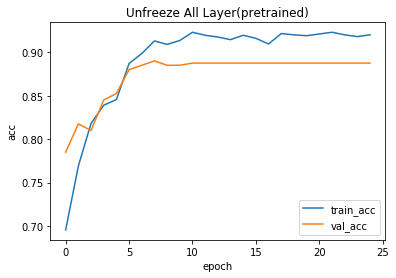

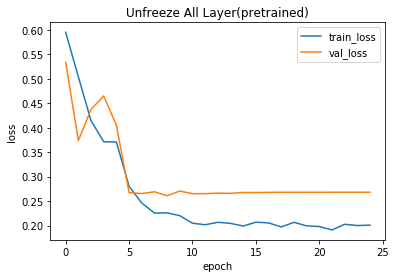

In [0]:
plot_acc_loss(model_ft_acc, model_ft_loss, 'Unfreeze All Layer(pretrained)')

**Visualizing the model predictions:**

1.   List item
2.   List item


Generic function to display predictions for a few images

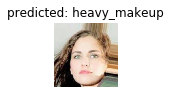

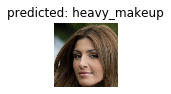

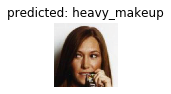

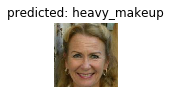

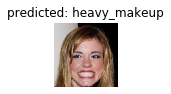

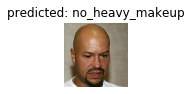

In [0]:
visualize_model(model_ft)

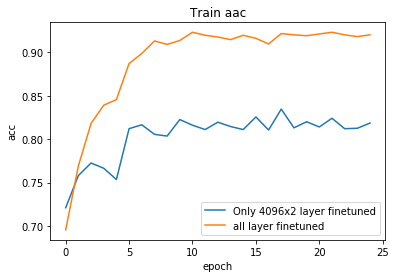

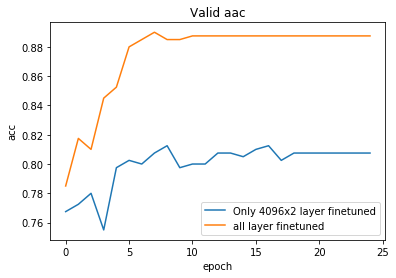

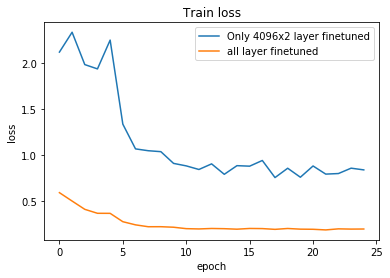

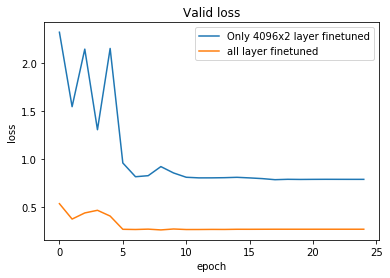

In [0]:
epoch_list = list(range(len(model_acc['train'])))
plt.plot(epoch_list, model_acc['train'], epoch_list, model_ft_acc['train'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Only 4096x2 layer finetuned', 'all layer finetuned'])
plt.title('Train aac')
plt.show()

plt.plot(epoch_list, model_acc['val'], epoch_list, model_ft_acc['val'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Only 4096x2 layer finetuned', 'all layer finetuned'])
plt.title('Valid aac')
plt.show()

plt.plot(epoch_list, model_loss['train'], epoch_list, model_ft_loss['train'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Only 4096x2 layer finetuned', 'all layer finetuned'])
plt.title('Train loss')
plt.show()

plt.plot(epoch_list, model_loss['val'], epoch_list, model_ft_loss['val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Only 4096x2 layer finetuned', 'all layer finetuned'])
plt.title('Valid loss')
plt.show()